In [1]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import os
from scipy.signal import savgol_filter  

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage import io
import copy
import gc
from joblib import dump
from sklearn.decomposition import PCA


In [2]:
B_SIZE = 256
img_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class CelebA_Dataset(Dataset):
    def __init__(self, data_dir, split, transform):
        super().__init__()
        self.img_dir = os.path.join(data_dir + "/img_align_celeba")
        self.data_dir = data_dir
        self.split = split
        self.transform = transform
        self.make_split()
    
    def make_split(self):
        partition_list_path = os.path.join(self.data_dir, "list_eval_partition.txt")
        partition_list = np.loadtxt(partition_list_path, dtype=str)
        if self.split == "train":
            self.img_names = partition_list[partition_list[:, 1].astype(float) == 0, 0]
        elif self.split == "test":
            self.img_names = partition_list[partition_list[:, 1].astype(float) > 0, 0]
            
    def t(self, img):
        return self.transform(img)
        
    def __len__(self):
        return len(self.img_names)
    
    def t(self, img):
        return self.transform(img)
        
    def __getitem__(self, idx):
        if type(idx) != int:
            file_names = [os.path.join(self.img_dir, self.img_names[id]) for id in idx]
            imgs = []
            for name in file_names:
                img = np.array(Image.open(name))
                if self.transform:
                    img = self.t(img)
                imgs.append(img)
            return np.stack(imgs)
                             
        file_name = os.path.join(self.img_dir, self.img_names[idx])
        img = np.array(Image.open(file_name))
        
        if self.transform:
            img = self.t(img)
    
        return img

In [ ]:
t = transforms.Compose([transforms.ToTensor(),
                        transforms.Resize((img_size, img_size)),
#                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                       ])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((img_size, img_size)),
#                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                    ])

In [ ]:
train_dataset = CelebA_Dataset("./data", "train", t)
test_dataset = CelebA_Dataset("./data", "test", test_transform)

In [ ]:
def visual(img_to_display=4):
    print("Displaying images in the dataset")
    fig, ax = plt.subplots(1, img_to_display)
    fig.set_size_inches(25, 8)
    
    for id in range(img_to_display):
        ax[id].imshow(test_dataset[id].permute(1,2,0))
        ax[id].axis("off")
    plt.tight_layout()
    plt.show()

Displaying images in the dataset


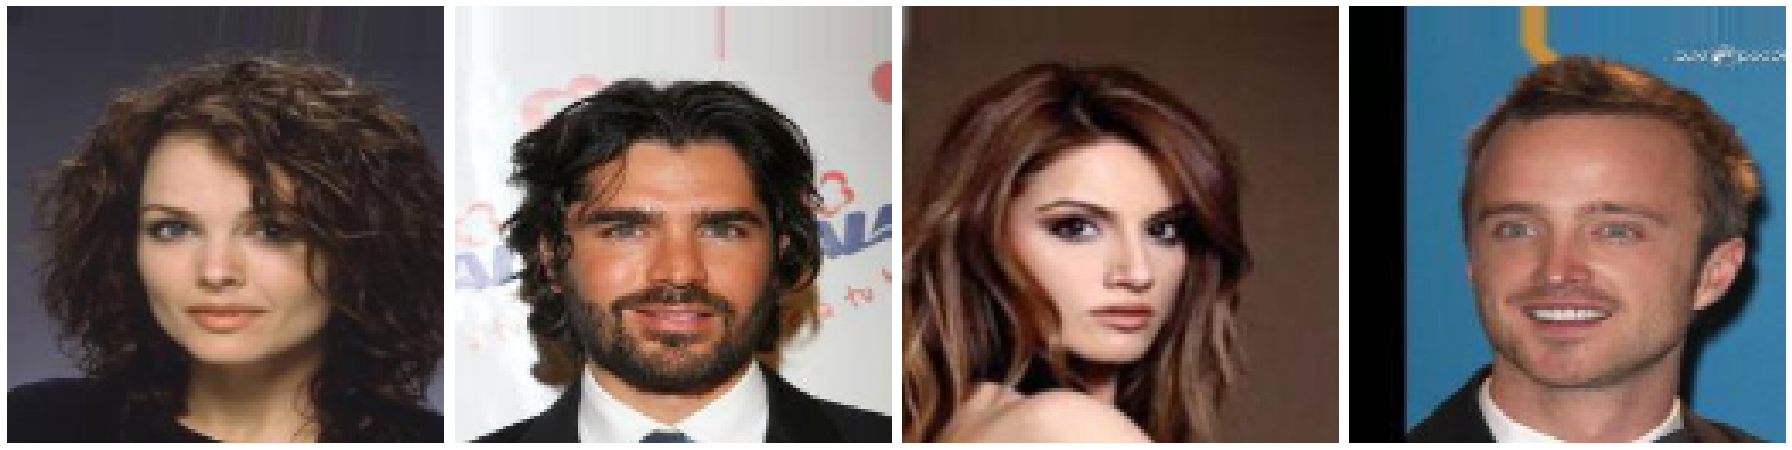

In [ ]:
visual()

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=B_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=B_SIZE, shuffle=True, num_workers=4, pin_memory=True)

In [ ]:
"""
Reference: https://github.com/AntixK/PyTorch-VAE/blob/master/models/cvae.py
with modificaiton and some help from a friend
"""

class ConvVAE(nn.Module):

    def __init__(self, in_channels=3, out_channels=[32, 64, 128, 256, 512], latent_dim=128, fc_dim=512*4*4):
        """ Model initlaizer """

        super().__init__()

        self.out_channels = out_channels
        self.fc_dim = fc_dim
        self.latent_dim = latent_dim
        self.img_channel = in_channels
        self.encoder = self._make_encoder()
        self.decoder = self._make_decoder()
        self.fc_mu = nn.Linear(fc_dim, latent_dim)
        self.fc_sigma = nn.Linear(fc_dim, latent_dim)

        return

 
    def _make_encoder(self):
        layers = []
        in_channels = self.img_channel
        for h_dim in self.out_channels:
            layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        encoder = nn.Sequential(*layers)

        return encoder

    def _make_decoder(self):

        modules = []

        self.decoder_input = nn.Linear(self.latent_dim, self.fc_dim)

        self.out_channels.reverse()

        for i in range(len(self.out_channels) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(self.out_channels[i],
                                       self.out_channels[i + 1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(self.out_channels[i + 1]),
                    nn.LeakyReLU())
            )

        decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(self.out_channels[-1],
                               self.out_channels[-1],
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.BatchNorm2d(self.out_channels[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(self.out_channels[-1], out_channels=3,
                      kernel_size=3, padding=1),
            nn.Tanh())
        return decoder

    def encode(self,x):
        out = self.encoder(x)
        out = torch.flatten(out, 1)
        mu = self.fc_mu(out)
        log_var = self.fc_sigma(out)

        return mu, log_var
    
    def decode(self,z):
        z_in = self.decoder_input(z)
        z_in = z_in.view(-1, 512, 4, 4)
        x_hat = self.decoder(z_in)
        x_hat = self.final_layer(x_hat)

        return x_hat
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std) 
        return mu + std * eps
        

    def forward(self, x):
        
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decode(z)

        return x_hat, mu, log_var

In [ ]:
def train(model, train_loader, optimizer, epoch):
    """
    Training for one epoch
    """
    loss_list = []
    running_loss = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    model.train()
    
    for idx, images in pbar:
       
        # put on gpu
        images = images.to(device)
        model = model.to(device)
        
        optimizer.zero_grad()
        
        img_recon, mu, logVar = model(images)

        kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())

        loss =  F.mse_loss(img_recon, images, reduction="sum") + kl_divergence

        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        running_loss =+ loss.item()
        
        if idx % 1 == 0:
            pbar.set_description(f"Epoch {epoch+1}, Itr {idx+1}, Loss {running_loss:.5f}")

    avg_loss = np.mean(loss_list)

    return loss_list, avg_loss

@torch.no_grad()
def testing(model, test_loader):
    """
    Testing the accuracy for validation set
    """
    model.eval()
    correct = 0
    loss_list = []
    pbar = tqdm(enumerate(test_loader), total=len(test_loader))

    for idx, images in pbar:
        images = images.to(device)
        model = model.to(device)
        
        img_recon, mu, logVar = model(images)

        kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())

        loss = F.mse_loss(img_recon, images, reduction="sum") + kl_divergence
        
        loss_list.append(loss.item())

    return np.mean(loss_list)
        
def training_model(model, optimizer, scheduler, train_loader, valid_loader, num_epochs):
    """
    Training and testing of model for N number of EPOCHS
    """
    stats = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "loss_iters":[]
    }
    for epoch in range(num_epochs):
        # testing 
        v_loss = testing(model, valid_loader)
        stats["val_loss"].append(v_loss)
        
        # training epoch
        stats['epoch'].append(epoch+1)
        
        epoch_loss_list, epoch_loss = train(model, train_loader, optimizer, epoch)
        scheduler.step()
        
        stats["train_loss"].append(epoch_loss)
        stats["loss_iters"] = stats["loss_iters"] + epoch_loss_list
            
        saving_model(model, optimizer, epoch, stats)
        print(f"Loss for epoch: {epoch+1} is: ", stats["val_loss"][-1])

    print(f"Training completed")

In [4]:
def num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def saving_model(model, optimizer, epoch, stats,resnet= False):
    if not os.path.exists("models"):
        os.makedirs("models")
    if(resnet):
      save_path = f"models/ResNetVAE_{epoch+1}.pth"
    else:
      save_path = f"models/ConvVAE_{epoch+1}.pth"
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, save_path)
    

def loading_model(model, path):
    optimizer = torch.optim.Adam(params=model.parameters(), lr= 3e-4)
    checkpoint =  torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    stats = checkpoint['stats']
    return model, optimizer, epoch, stats

def smooth(f):
    smooth_f = savgol_filter(f, 51, 3)
    return smooth_f


In [ ]:
def training_full_model(model, train_loader, valid_loader, num_epochs):
    LR = 3e-4
    optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    training_model(model, optimizer, scheduler, train_loader, valid_loader, num_epochs)

In [ ]:
convVae = ConvVAE()

In [ ]:
training_full_model(convVae, train_loader, test_loader, 30)

Epoch 1, Itr 636, Loss 166657.64062: 100%|████| 636/636 [03:52<00:00,  2.74it/s]


Loss for epoch: 1 is:  3381493.0713141025


Epoch 2, Itr 636, Loss 143382.35938: 100%|████| 636/636 [03:55<00:00,  2.70it/s]


Loss for epoch: 2 is:  202003.25265424678


Epoch 3, Itr 636, Loss 137756.34375: 100%|████| 636/636 [03:49<00:00,  2.77it/s]


Loss for epoch: 3 is:  175994.29166666666


Epoch 4, Itr 636, Loss 134593.65625: 100%|████| 636/636 [03:48<00:00,  2.79it/s]


Loss for epoch: 4 is:  169230.19100560897


Epoch 5, Itr 636, Loss 131938.93750: 100%|████| 636/636 [03:48<00:00,  2.78it/s]


Loss for epoch: 5 is:  161305.1252003205


Epoch 6, Itr 636, Loss 125186.30469: 100%|████| 636/636 [03:48<00:00,  2.79it/s]


Loss for epoch: 6 is:  158009.87570112178


Epoch 7, Itr 636, Loss 126373.73438: 100%|████| 636/636 [03:48<00:00,  2.79it/s]

Loss for epoch: 7 is:  155910.56169871794



Epoch 8, Itr 636, Loss 124870.87500: 100%|████| 636/636 [03:48<00:00,  2.78it/s]

Loss for epoch: 8 is:  152643.93434495194



Epoch 9, Itr 636, Loss 121917.95312: 100%|████| 636/636 [03:48<00:00,  2.79it/s]


Loss for epoch: 9 is:  148147.75701121794


Epoch 10, Itr 636, Loss 125323.10156: 100%|███| 636/636 [03:48<00:00,  2.79it/s]

Loss for epoch: 10 is:  147951.79442107372



Epoch 11, Itr 636, Loss 123123.76562: 100%|███| 636/636 [03:48<00:00,  2.79it/s]

Loss for epoch: 11 is:  147715.58248197116



Epoch 12, Itr 636, Loss 118625.69531: 100%|███| 636/636 [03:47<00:00,  2.79it/s]


Loss for epoch: 12 is:  147663.5179286859


Epoch 13, Itr 636, Loss 120269.36719: 100%|███| 636/636 [03:47<00:00,  2.79it/s]

Loss for epoch: 13 is:  146868.47686298078



Epoch 14, Itr 636, Loss 121102.78125: 100%|███| 636/636 [03:48<00:00,  2.79it/s]

Loss for epoch: 14 is:  146150.23307291666



Epoch 15, Itr 636, Loss 120943.32812: 100%|███| 636/636 [03:48<00:00,  2.79it/s]


Loss for epoch: 15 is:  145920.9520733173


Epoch 16, Itr 636, Loss 120605.46875: 100%|███| 636/636 [03:47<00:00,  2.79it/s]

Loss for epoch: 16 is:  145193.6294571314



Epoch 17, Itr 636, Loss 116522.45312: 100%|███| 636/636 [03:48<00:00,  2.79it/s]

Loss for epoch: 17 is:  145126.8895733173



Epoch 18, Itr 636, Loss 120748.34375: 100%|███| 636/636 [03:47<00:00,  2.79it/s]


Loss for epoch: 18 is:  145053.3446514423


Epoch 19, Itr 636, Loss 120360.32031: 100%|███| 636/636 [03:48<00:00,  2.79it/s]

Loss for epoch: 19 is:  145017.17693309294



Epoch 20, Itr 636, Loss 115923.43750: 100%|███| 636/636 [03:48<00:00,  2.79it/s]

Loss for epoch: 20 is:  144950.15454727566



Epoch 21, Itr 636, Loss 116728.35938: 100%|███| 636/636 [03:48<00:00,  2.79it/s]


Loss for epoch: 21 is:  145004.92237580128


Epoch 22, Itr 636, Loss 117476.85156: 100%|███| 636/636 [03:48<00:00,  2.79it/s]

Loss for epoch: 22 is:  144850.80724158653



Epoch 23, Itr 636, Loss 119066.86719: 100%|███| 636/636 [03:48<00:00,  2.78it/s]

Loss for epoch: 23 is:  144844.0967548077



Epoch 24, Itr 636, Loss 121279.44531: 100%|███| 636/636 [03:48<00:00,  2.79it/s]


Loss for epoch: 24 is:  144880.80809294872


Epoch 25, Itr 636, Loss 122537.28125: 100%|███| 636/636 [03:48<00:00,  2.79it/s]

Loss for epoch: 25 is:  144872.96955128206



Epoch 26, Itr 636, Loss 117642.44531: 100%|███| 636/636 [03:47<00:00,  2.79it/s]

Loss for epoch: 26 is:  144849.51677684294



Epoch 27, Itr 636, Loss 117761.91406: 100%|███| 636/636 [03:48<00:00,  2.78it/s]


Loss for epoch: 27 is:  144794.01772836538


Epoch 28, Itr 636, Loss 116574.57031: 100%|███| 636/636 [03:46<00:00,  2.81it/s]

Loss for epoch: 28 is:  144787.39908854166



Epoch 29, Itr 636, Loss 115418.67188: 100%|███| 636/636 [03:46<00:00,  2.80it/s]

Loss for epoch: 29 is:  144791.1837940705



Epoch 30, Itr 636, Loss 117518.43750: 100%|███| 636/636 [03:46<00:00,  2.81it/s]


Loss for epoch: 30 is:  144733.63131009616
Training completed


In [ ]:
def img_regeneration(model):
    with torch.no_grad():
        num_preds = 16
        test_z = torch.normal(0, 1, size=(1, 128))
        out = model.decode(test_z)
        out = out[0].permute(1,2,0)
    return out

In [ ]:
conv_model, optimizer, epoch, stats = loading_model(convVae, "models/ConvVAE_30.pth")

In [ ]:
out = img_regeneration(conv_model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 127.5, 127.5, -0.5)

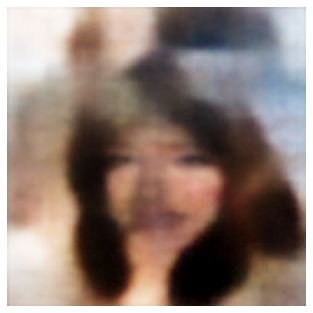

In [ ]:
plt.imshow(out.to("cpu"))
plt.axis("off")

## Training-Validation Plots

So now is the time to see how the plots look like. As one can see validation loss started larger tham training loss since we are testing first and then training, but the loss plumted and after 10 epochs it was already much lower than when it started. 

* After 16 epochs the loss never really changed. But if we observe closly we see that the training loss was much larger than the validation loss.

* There is another thing that we observed, the value of our loss is pretty high even though the regenerated images are quite realistic. Is there something that we missed doing?

## Loss per iteration

* Here we are displaying loss after the first 1000 iterstions since in the beginning the loss was pretty high and it was messing up the visualizations.

* Secondly there are these dips in the loss value at regular intervals. We can't rule them out as outliers since there are too many. Still in wonderment if it is common or did the training sequence encounter an easier batch of images. 


Text(0.5, 1.0, '')

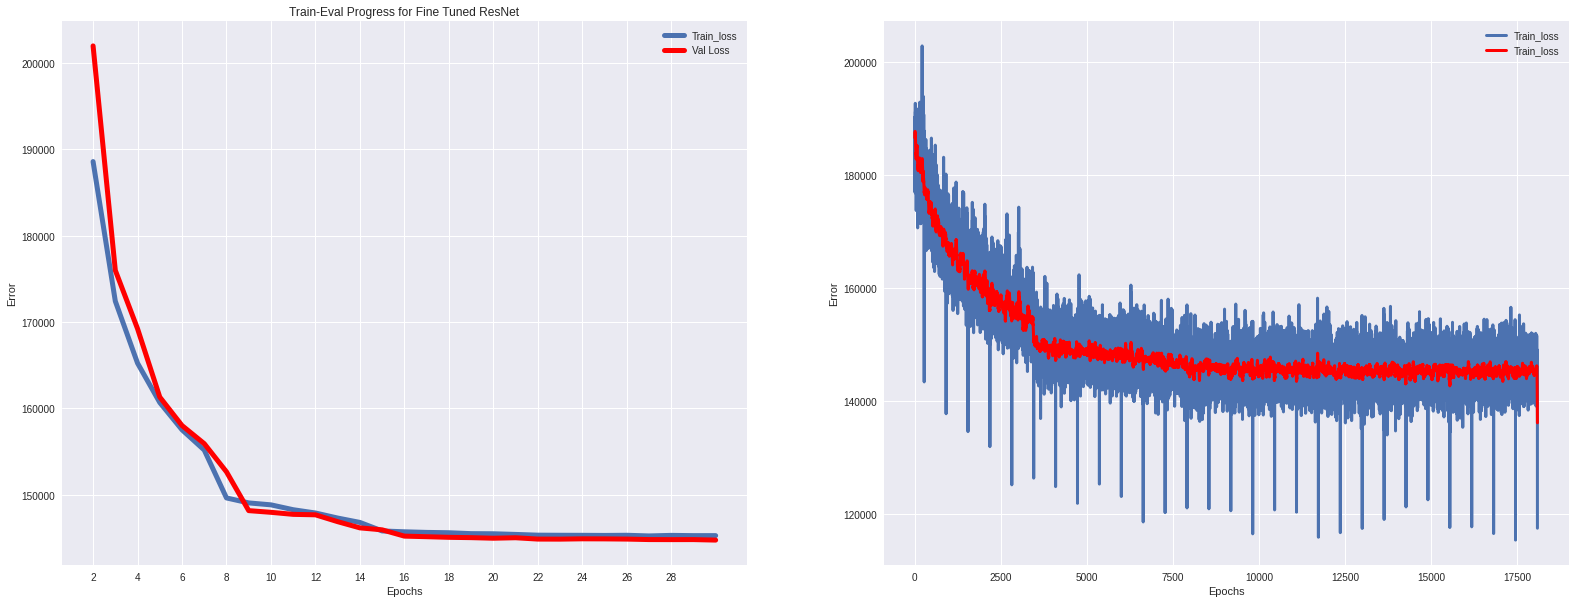

In [ ]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(27, 10)

smooth_loss = smooth(stats['loss_iters'][1000:])
ax[0].plot(stats['epoch'][1:], stats['train_loss'][1:], label="Train_loss", linewidth=5)
ax[0].plot(stats['epoch'][1:], stats['val_loss'][1:], label="Val Loss", c='red', linewidth=5)
ax[0].legend(loc='best')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Error")
ax[0].set_xticks(np.arange(2, 29, step=2))

ax[0].set_title("Train-Eval Progress for Fine Tuned ResNet")


ax[1].plot(stats['loss_iters'][1000:], label="Train_loss", linewidth=3)
ax[1].plot(smooth_loss, label="Train_loss", linewidth=3, c='red')

ax[1].legend(loc='best')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Error")
# ax[1].set_xticks(np.arange(2, 29, step=2))

ax[1].set_title("")

## Interpolations

Here we see how the regenerations look when we change the hidden vector. Since there were 128 dims of the hidden space and changing each of the dim would have resulted in different images. So we chose the hidden vector such that all the values of z are same when regenerating one image and the value of z range from -1 to 1 for all the 64 images regenerated.

* It can be seen that the model is able to learn faces and other facial features.

* For lower values of z it has more masculine features and for higher values the regenerated images have more feminine features.

In [ ]:
@torch.no_grad()
def plot_interpolations(model, xrange=(-1, 1), N=64):
    all_img = []
    for x in torch.linspace(*xrange, N):
        z = x.repeat(128)
        x_hat = model.decode(z)
        all_img.append(x_hat)

    all_img = torch.cat(all_img)
    grid_imgs = torchvision.utils.make_grid(all_img, nrows=4)
    plt.figure(figsize=(12,20))
    plt.imshow(grid_imgs.permute(1, 2, 0))
    plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


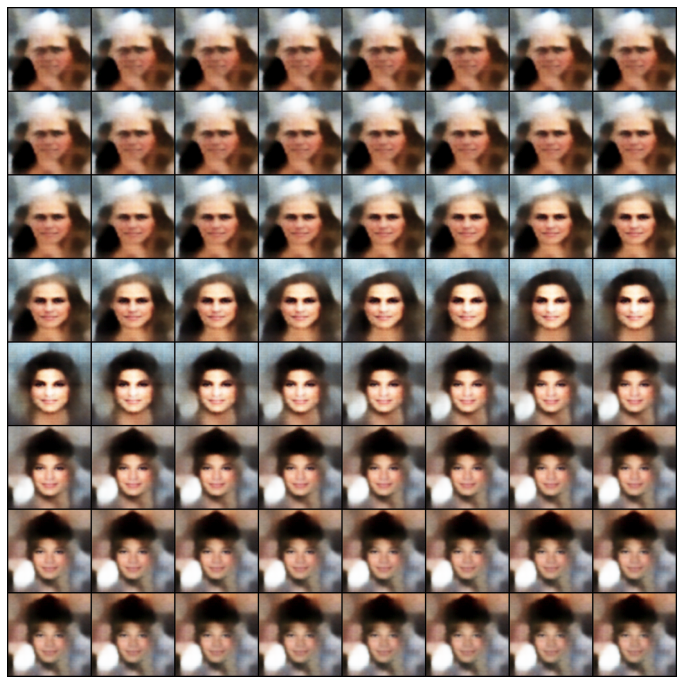

In [ ]:
plot_interpolations(conv_model)

Here we are visualizing the regenerated images which are way beyond the distribution that we chose for our hidden vectors, just to see how these images would look like. 

* It turns out the image on the left has no facial features at all but looks like an art piece of sorts

* And the image on the right which lies on the other end of distribution has some facial featues but still not at all related to the images in the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


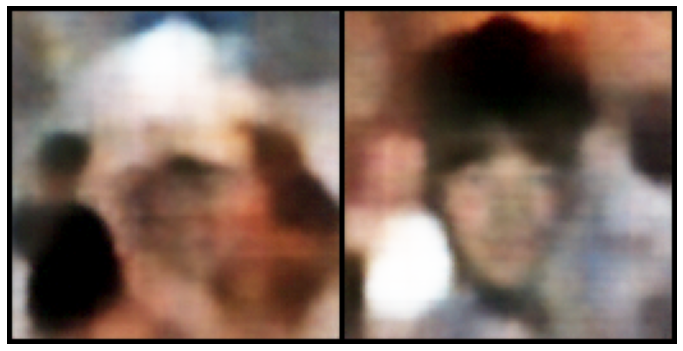

In [ ]:
plot_interpolations(conv_model, xrange=(-10, 10), N=2)

# Hidden Dimensions 

Here we will plot how the hidden dimenstions are and where they lie in space. Since we don't have labels to our images we will show you the PCA projection of hidden vector for an image of a human male and human female.

* So the first 2 images are pretty close in the embedding space, the reason could be that the general camera angle and features are quite similar, they both have somewhat long hair as well and have a slight smile. 

* But the other 2 images are pretty far away from each other as well as the images in the previous set. The reason could be that image 3 has pretty differnt camera angle than all, thus it lies at the extreme side of plot. But the reason image 4 is so far away is undefined

Displaying images in the dataset


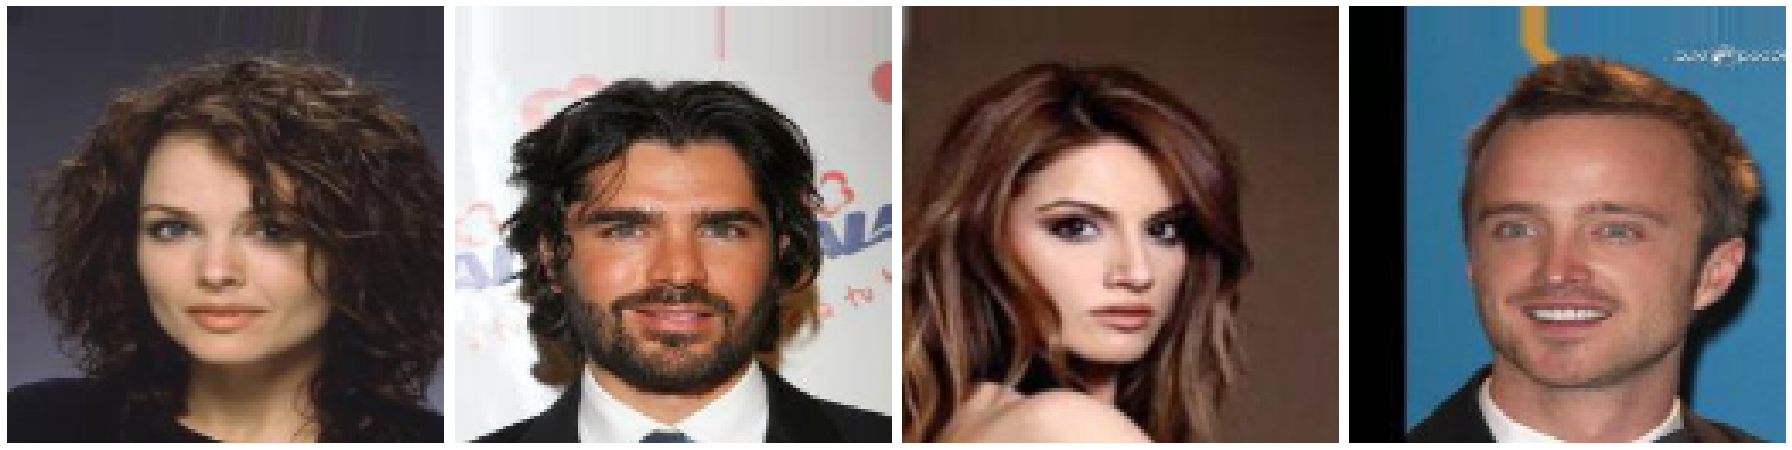

In [ ]:
visual(img_to_display=4)

In [ ]:
with torch.no_grad():
    imgs_male = torch.Tensor(test_dataset[[1, 3]])
    imgs_female = torch.Tensor(test_dataset[[0, 2]])
    vis_data = torch.cat([imgs_male, imgs_female])
    mu, sigma = conv_model.encode(vis_data)
    z = conv_model.reparameterize(mu, sigma)
    

In [ ]:
pca_imgs = PCA(n_components=2).fit_transform(z)

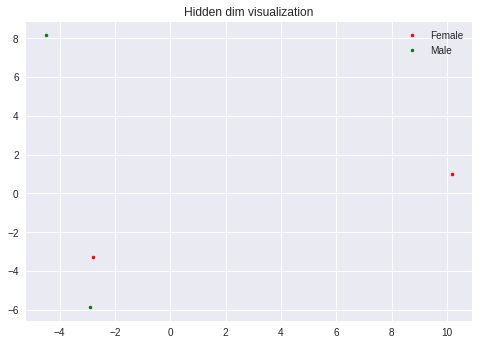

In [ ]:
label_idx = np.array([[0, 2],
               [1, 3]])
id2label = {0:"Female", 1:"Male"}
for i, color in enumerate(['r', 'g']):
    plt.plot(pca_imgs[label_idx[i], 0], pca_imgs[label_idx[i], 1], marker= '.', linestyle="None", color=color, label=id2label[i])
    plt.legend(loc='best')
    plt.title("Hidden dim visualization")

In [5]:
%mkdir data

mkdir: cannot create directory ‘data’: File exists


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
#!unzip /content/drive/MyDrive/cuda/sheet6/data/img_align_celeba.zip -d /content/data

In [7]:
!cp /content/drive/MyDrive/cuda/sheet6/data/list_eval_partition.txt /content/data

In [23]:
t = transforms.Compose([transforms.ToTensor(),
                        transforms.Resize((64, 64)),
#                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                       ])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((64, 64)),
#                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                    ])

In [24]:
train_dataset = CelebA_Dataset("/content/data", "train", t)
test_dataset = CelebA_Dataset("/content/data", "test", test_transform)

In [25]:
train_loader = DataLoader(train_dataset, batch_size=B_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=B_SIZE, shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [26]:
"""
Reference: https://github.com/julianstastny/VAE-ResNet18-PyTorch
with some modificaitons and using images of size 64 * 64
"""

class RConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class BlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.encoder = nn.Sequential()
        else:
            self.encoder = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.encoder(x)
        out = torch.relu(out)
        return out

class BlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)

        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.decoder = nn.Sequential()
        else:
            self.conv1 = RConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.decoder = nn.Sequential(
                RConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.decoder(x)
        out = torch.relu(out)
        return out

class ResNet18Enc(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], btl_dim=10, nc=3):
        super().__init__()
        self.in_planes = 64
        self.btl_dim = btl_dim
        self.conv1 = nn.Conv2d(nc, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BlockEnc, 64, num_Blocks[0], stride=1)
        self.layer2 = self._make_layer(BlockEnc, 128, num_Blocks[1], stride=2)
        self.layer3 = self._make_layer(BlockEnc, 256, num_Blocks[2], stride=2)
        self.layer4 = self._make_layer(BlockEnc, 512, num_Blocks[3], stride=2)
        self.linear = nn.Linear(512, 2 * btl_dim)

    def _make_layer(self, BlockEnc, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in strides:
            layers += [BlockEnc(self.in_planes, stride)]
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        mu = x[:, :self.btl_dim]
        logvar = x[:, self.btl_dim:]
        return mu, logvar

class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], btl_dim=10, nc=3):
        super().__init__()
        self.in_planes = 512

        self.linear = nn.Linear(btl_dim, 512)

        self.layer4 = self._make_layer(BlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BlockDec, 64, num_Blocks[0], stride=1)
        self.conv1 = RConv2d(64, nc, kernel_size=3, scale_factor=2)

    def _make_layer(self, BlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 512, 1, 1)
        x = F.interpolate(x, scale_factor=4)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = torch.sigmoid(self.conv1(x))
        x = x.view(x.size(0), 3, 64, 64)
        return x

class ResnetVAE(nn.Module):

    def __init__(self, btl_dim):
        super().__init__()
        self.encoder = ResNet18Enc(btl_dim=btl_dim)
        self.decoder = ResNet18Dec(btl_dim=btl_dim)

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        x = self.decoder(z)
        return x, (z,mean,logvar)

    def reparameterize(self, mu, log_var):
        """ Reparametrization trick"""
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)  # random sampling happens here
        z = mu + std * eps
        return z

In [27]:
rVae = ResnetVAE(10)
rVae


ResnetVAE(
  (encoder): ResNet18Enc(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BlockEnc(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (encoder): Sequential()
      )
      (1): BlockEnc(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (

In [28]:
def vae_loss_function(recons, target, mu, log_var, lambda_recons=1, lambda_elbo=1):
    
    recons_loss = F.mse_loss(recons, target, reduction="sum")
    b_size = recons.shape[0]
    elbo = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return (lambda_recons * recons_loss + lambda_elbo * elbo) / b_size, (recons_loss, elbo)

In [36]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    recons_loss = []
    vae_loss = []
    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    model.train()

    for idx, images in pbar:

        images = images.to(device)
        model = model.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass
        recons, (z, mu, log_var) = model(images)
        
         
        # Calculate Loss
        loss, (mse, kld) = criterion(recons, images, mu, log_var)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        vae_loss.append(kld.item())
        
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
        pbar.set_description(f"Epoch {epoch+1} Iter {idx+1}: loss {loss.item():.5f}. ")
        
    mean_loss = np.mean(loss_list)
    
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device, epoch=None):
    """ Evaluating the model for either validation or test """
    model.eval()
    loss_list = []
    recons_loss = []
    vae_loss = []
    
    pbar = tqdm(enumerate(test_loader), total=len(test_loader))

    for idx, images in pbar:
        images = images.to(device)
        model = model.to(device)
        
        # Forward pass 
        recons, (z, mu, log_var) = model(images)
                 
        loss, (mse, kld) = criterion(recons, images, mu, log_var)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        vae_loss.append(kld.item())
        
        
            
    # Total correct predictions and loss
    loss = np.mean(loss_list)
        
    return loss


In [30]:
def train_model(model, optimizer, scheduler, criterion, train_loader,
                valid_loader, num_epochs):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    loss_iters = []
    stats = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "loss_iters":[]
    }
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        log_epoch = (epoch % 5 == 0 or epoch == num_epochs - 1)
        loss = eval_model(
                model=model, eval_loader=valid_loader, criterion=criterion,
                device=device, epoch=epoch)
        val_loss.append(loss)
        stats["val_loss"].append(loss)
        
        # training epoch
        stats['epoch'].append(epoch+1)
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
        
        # PLATEAU SCHEDULER
        scheduler.step(val_loss[-1])
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        stats["train_loss"].append(mean_loss)
        stats["loss_iters"] = stats["loss_iters"] + cur_loss_iters

        saving_model(model, optimizer, epoch, stats, resnet= True)
        
       
            
        
        if(log_epoch):
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters

In [37]:
model = rVae
optimizer = torch.optim.Adam(rVae.parameters(), lr=3e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1, verbose=True)

In [38]:
def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

In [39]:
count_model_params(rVae)

23728791

In [41]:
train_loss, val_loss, loss_iters = train_model(
        model=model, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=10
    )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Epoch 1 Iter 636: loss 530.86688. : 100%|██████████| 636/636 [08:33<00:00,  1.24it/s]


    Train loss: 533.06531
    Valid loss: 553.93427


Epoch 6 Iter 636: loss 465.07925. : 100%|██████████| 636/636 [08:32<00:00,  1.24it/s]


    Train loss: 471.2382
    Valid loss: 535.98852


Epoch 10 Iter 636: loss 453.15836. : 100%|██████████| 636/636 [08:33<00:00,  1.24it/s]


    Train loss: 451.97284
    Valid loss: 521.47008
Training completed


In [67]:
resnet_model, optimizer, epoch, stats = loading_model(rVae, "models/ResNetVAE_10.pth")

In [68]:
def img_regeneration(model):
    with torch.no_grad():
        num_preds = 16
        test_z =next(iter(train_loader))
        test_z= test_z.to(device)
        out = model(test_z)
        
    return out

In [69]:
out,(_,_,_) = img_regeneration(resnet_model)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [70]:
out[0].shape
a=out[0].permute(1,2,0)

(-0.5, 63.5, 63.5, -0.5)

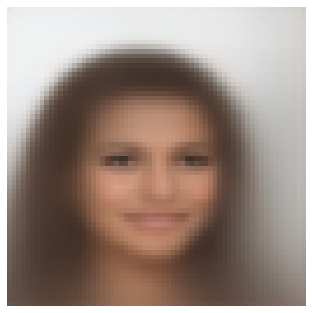

In [71]:
plt.imshow(a.to("cpu"))
plt.axis("off")

Text(0.5, 1.0, '')

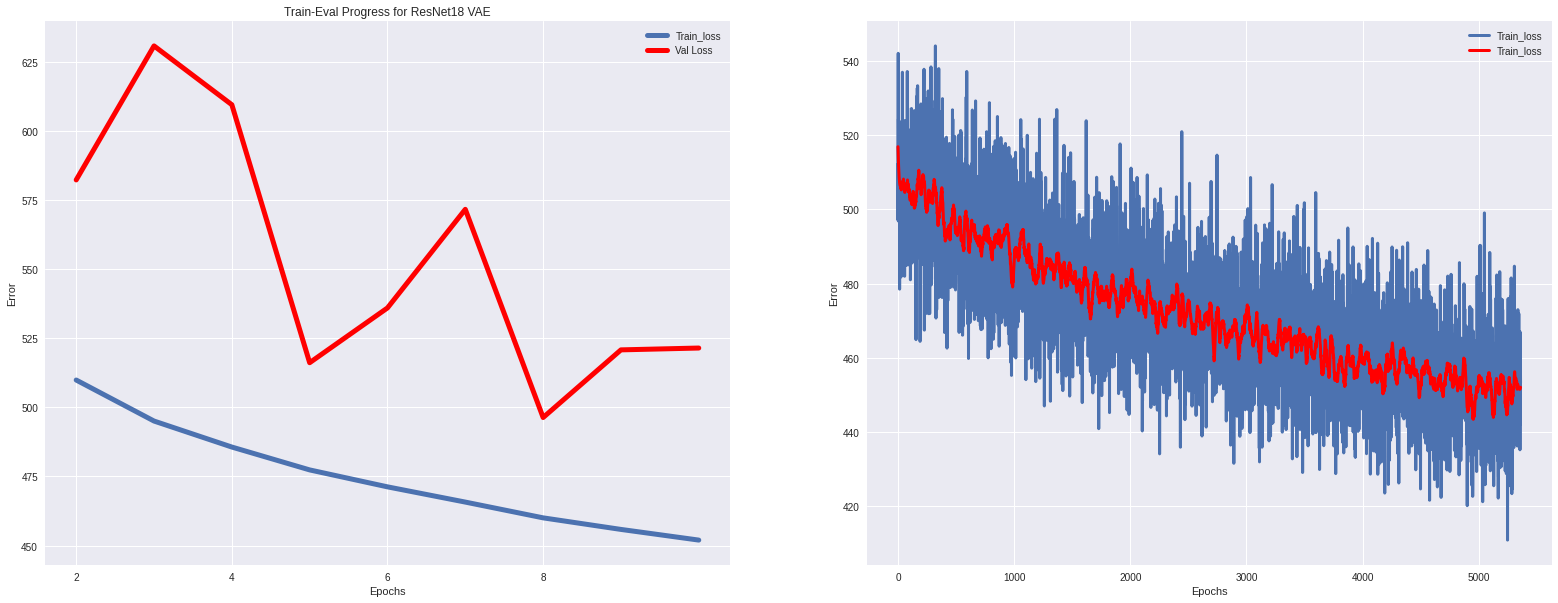

In [72]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(27, 10)

smooth_loss = smooth(stats['loss_iters'][1000:])
ax[0].plot(stats['epoch'][1:], stats['train_loss'][1:], label="Train_loss", linewidth=5)
ax[0].plot(stats['epoch'][1:], stats['val_loss'][1:], label="Val Loss", c='red', linewidth=5)
ax[0].legend(loc='best')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Error")
ax[0].set_xticks(np.arange(2, 10, step=2))

ax[0].set_title("Train-Eval Progress for ResNet18 VAE")


ax[1].plot(stats['loss_iters'][1000:], label="Train_loss", linewidth=3)
ax[1].plot(smooth_loss, label="Train_loss", linewidth=3, c='red')

ax[1].legend(loc='best')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Error")

ax[1].set_title("")

The validation loss spikes instead of being a smooth downward curve this could be due to the split of the validation set or issues with the learning rate it might also be something else entirely , while the training loss decreases properly for over 10 epochs.